# Exercise 3 : Text classification on the Ohsumed dataset
## 1. Data loading and preprocessing


In [48]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
from collections import defaultdict
from keras.preprocessing.text import text_to_word_sequence, Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences   # to do padding or truncating
import nltk
from nltk.corpus import stopwords   # to get collection of stopwords
import pandas as pd    # to load dataset
import numpy as np     # for mathematic equation
from nltk.corpus import stopwords   # to get collection of stopwords
from tensorflow.keras.layers import Bidirectional, Dropout
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.text import Tokenizer  # to encode text to int
from tensorflow.keras.preprocessing.sequence import pad_sequences   # to do padding or truncating
from tensorflow.keras.models import Sequential     # the model
from tensorflow.keras.layers import Embedding, LSTM, Dense # layers of the architecture
from tensorflow.keras.callbacks import ModelCheckpoint   # save model
from tensorflow.keras.models import load_model   # load saved model
import re
import matplotlib.pyplot as plt


In [49]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/maelkerichard/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [50]:
def get_info(path: str):
    data = list(os.walk(path))[1:]
    files = []
    for d in data:
        folder_name = d[0]
        for file in d[2]:
            files.append((folder_name.split('/')[-1], os.path.join(folder_name, file)))

    d = defaultdict(int)
    texts = defaultdict(list)
    for (cate, file) in files:
        with open(file, 'r') as outfile:
            text = outfile.read()
            texts[cate].append(text)
            words = text_to_word_sequence(text)
            for word in words:
                d[word] += 1
    words = sorted(d.items(), key=lambda x: x[1], reverse=True)
    return (texts, words)

In [51]:
english_stops = set(stopwords.words('english'))

In [52]:
def load_dataset(folder):

    # LOAD DATA
    path = '../ohsumed-first-20000-docs/' + folder
    texts, words = get_info(path)
    
    # CREATE DATAFRAME
    df = pd.DataFrame(columns=['category', 'article'])
    for cate in texts:
        for text in texts[cate]:
            df = pd.concat([df, pd.DataFrame({'category': [cate], 'article': [text]})], ignore_index=True)
    
    # PRE-PROCESS DATA
    df['article'] = df['article'].replace({'<.*?>': ''}, regex = True)          # remove html tag
    df['article'] = df['article'].replace({'[^A-Za-z]': ' '}, regex = True)     # remove non alphabet
    df['article'] = df['article'].apply(lambda article: [w for w in article.split() if w not in english_stops])  # remove stop words
    df['article'] = df['article'].apply(lambda article: [w.lower() for w in article])   # lower case
    
    # ENCODE CATEGORY
    df['category'] = df['category'].replace('C01', 0)
    df['category'] = df['category'].replace('C02', 1)
    df['category'] = df['category'].replace('C03', 2)
    df['category'] = df['category'].replace('C04', 3)
    df['category'] = df['category'].replace('C05', 4)
    df['category'] = df['category'].replace('C06', 5)
    df['category'] = df['category'].replace('C07', 6)
    df['category'] = df['category'].replace('C08', 7)
    df['category'] = df['category'].replace('C09', 8)
    df['category'] = df['category'].replace('C10', 9)
    df['category'] = df['category'].replace('C11', 10)
    df['category'] = df['category'].replace('C12', 11)
    df['category'] = df['category'].replace('C13', 12)
    df['category'] = df['category'].replace('C14', 13)
    df['category'] = df['category'].replace('C15', 14)
    df['category'] = df['category'].replace('C16', 15)
    df['category'] = df['category'].replace('C17', 16)
    df['category'] = df['category'].replace('C18', 17)
    df['category'] = df['category'].replace('C19', 18)
    df['category'] = df['category'].replace('C20', 19)
    df['category'] = df['category'].replace('C21', 20)
    df['category'] = df['category'].replace('C22', 21)
    df['category'] = df['category'].replace('C23', 22)

    # Join words in the articles to form a single string per article
    df['article'] = df['article'].apply(lambda x: ' '.join(x))

    x_data = df['article'].tolist()
    y_data = df['category']
    return x_data, y_data

In [53]:
x_train, y_train = load_dataset('training')
x_test, y_test = load_dataset('test')

In [54]:
# One-hot encode the labels
from tensorflow.keras.utils import to_categorical

NUM_CLASSES = 23  # Set this to the number of categories you have
y_train = to_categorical(y_train, num_classes=NUM_CLASSES)
y_test = to_categorical(y_test, num_classes=NUM_CLASSES)

In [55]:
y_train

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype=float32)

In [56]:
def get_max_length():
    review_length = []
    for article in x_train:
        review_length.append(len(article))

    return int(np.ceil(np.mean(review_length)))

In [57]:
# ENCODE REVIEW
token = Tokenizer(lower=False)    # no need lower, because already lowered the data in load_data()
token.fit_on_texts(x_train)
x_train = token.texts_to_sequences(x_train)
x_test = token.texts_to_sequences(x_test)

max_length = get_max_length()

x_train = pad_sequences(x_train, maxlen=max_length, padding='post', truncating='post')
x_test = pad_sequences(x_test, maxlen=max_length, padding='post', truncating='post')

total_words = len(token.word_index) + 1   # add 1 because of 0 padding

print('Encoded X Train\n', x_train, '\n')
print('Encoded X Test\n', x_test, '\n')
print('Maximum review length: ', max_length)

Encoded X Train
 [[  361   242    96 ...   119    96   354]
 [14808   668   464 ...     0     0     0]
 [ 1210    74    97 ...     0     0     0]
 ...
 [  669  1092  4038 ...  2897    21   669]
 [   39   240   132 ...     0     0     0]
 [    7  1270   254 ...   276  1859 13205]] 

Encoded X Test
 [[   74   837   711 ...     0     0     0]
 [ 1410   552    74 ...   552   240    45]
 [ 1037  1622    77 ...     0     0     0]
 ...
 [  128    21  1422 ...    30  3395  1536]
 [21723   470 12121 ...     0     0     0]
 [ 3106  5827   449 ...     0     0     0]] 

Maximum review length:  112


## Build Architecture/Model

In [65]:

# ARCHITECTURE
EMBED_DIM = 32
LSTM_OUT = 64
NUM_CLASSES = 23  # Number of classes

model = Sequential()
model.add(Embedding(total_words, EMBED_DIM, input_length=max_length))
model.add(LSTM(LSTM_OUT, return_sequences=True))
model.add(Dropout(0.1))
model.add(LSTM(LSTM_OUT))
model.add(Dropout(0.1))
model.add(Dense(NUM_CLASSES, activation='softmax'))  # Change for multiclass
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])  # Change loss function

print(model.summary())

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_7 (Embedding)     (None, 112, 32)           905888    
                                                                 
 lstm_9 (LSTM)               (None, 112, 64)           24832     
                                                                 
 dropout_3 (Dropout)         (None, 112, 64)           0         
                                                                 
 lstm_10 (LSTM)              (None, 64)                33024     
                                                                 
 dropout_4 (Dropout)         (None, 64)                0         
                                                                 
 dense_6 (Dense)             (None, 23)                1495      
                                                                 
Total params: 965239 (3.68 MB)
Trainable params: 96523

In [66]:
checkpoint = ModelCheckpoint(
    'models/LSTM.h5',
    monitor='accuracy',
    save_best_only=True,
    verbose=1
)

In [67]:
history = model.fit(x_train, y_train, batch_size = 128, epochs = 5, callbacks=[checkpoint])


Epoch 1/5
82/82 [==============================] - ETA: 0s - loss: 2.8686 - accuracy: 0.1654
Epoch 1: accuracy improved from -inf to 0.16544, saving model to models/LSTM.h5
82/82 [==============================] - 14s 150ms/step - loss: 2.8686 - accuracy: 0.1654
Epoch 2/5
82/82 [==============================] - ETA: 0s - loss: 2.7672 - accuracy: 0.1851
Epoch 2: accuracy improved from 0.16544 to 0.18509, saving model to models/LSTM.h5
82/82 [==============================] - 10s 126ms/step - loss: 2.7672 - accuracy: 0.1851
Epoch 3/5
82/82 [==============================] - ETA: 0s - loss: 2.7815 - accuracy: 0.1780
Epoch 3: accuracy did not improve from 0.18509
82/82 [==============================] - 11s 140ms/step - loss: 2.7815 - accuracy: 0.1780
Epoch 4/5
82/82 [==============================] - ETA: 0s - loss: 2.7423 - accuracy: 0.2021
Epoch 4: accuracy improved from 0.18509 to 0.20205, saving model to models/LSTM.h5
82/82 [==============================] - 11s 132ms/step - loss: 2

In [75]:
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.optimizers import Adam
import tensorflow as tf

# Assuming x_train, y_train, x_test, y_test are already prepared
x_train, y_train = load_dataset('training')
x_test, y_test = load_dataset('test')

# Hyperparameters (adjust as needed)
MAX_VOCAB_SIZE = 10000  # Consider reducing if you have memory constraints
EMBEDDING_DIM = 100  # Embedding dimensions
MAX_SEQUENCE_LENGTH = 500  # Adjust based on your data
NUM_CLASSES = 23  # Total number of classes
LEARNING_RATE = 0.001  # Start with this, adjust if necessary
BATCH_SIZE = 64
EPOCHS = 10

# Tokenization and Padding
tokenizer = Tokenizer(num_words=MAX_VOCAB_SIZE)
tokenizer.fit_on_texts(x_train)
sequences_train = tokenizer.texts_to_sequences(x_train)
sequences_test = tokenizer.texts_to_sequences(x_test)

word_index = tokenizer.word_index
print(f'Found {len(word_index)} unique tokens.')

x_train_padded = pad_sequences(sequences_train, maxlen=MAX_SEQUENCE_LENGTH)
x_test_padded = pad_sequences(sequences_test, maxlen=MAX_SEQUENCE_LENGTH)

# One-hot encode the labels
y_train_encoded = to_categorical(y_train, num_classes=NUM_CLASSES)
y_test_encoded = to_categorical(y_test, num_classes=NUM_CLASSES)

# Model definition
model = Sequential()
model.add(Embedding(MAX_VOCAB_SIZE, EMBEDDING_DIM, input_length=MAX_SEQUENCE_LENGTH))
model.add(LSTM(128, return_sequences=True))
model.add(Dropout(0.5))
model.add(LSTM(128))
model.add(Dropout(0.5))
model.add(Dense(NUM_CLASSES, activation='softmax'))

model.compile(optimizer=tf.keras.optimizers.legacy.Adam(learning_rate=LEARNING_RATE), loss='categorical_crossentropy', metrics=['accuracy'])
print(model.summary())

# Training the model
checkpoint = ModelCheckpoint('models/LSTM_improved.h5', monitor='val_accuracy', save_best_only=True, verbose=1)
history = model.fit(x_train_padded, y_train_encoded, batch_size=BATCH_SIZE, epochs=EPOCHS, validation_data=(x_test_padded, y_test_encoded), callbacks=[checkpoint])

Found 28308 unique tokens.
Model: "sequential_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_11 (Embedding)    (None, 500, 100)          1000000   
                                                                 
 lstm_17 (LSTM)              (None, 500, 128)          117248    
                                                                 
 dropout_11 (Dropout)        (None, 500, 128)          0         
                                                                 
 lstm_18 (LSTM)              (None, 128)               131584    
                                                                 
 dropout_12 (Dropout)        (None, 128)               0         
                                                                 
 dense_10 (Dense)            (None, 23)                2967      
                                                                 
Total params: 1251799 (4.7

/Users/maelkerichard/Library/Python/3.9/lib/python/site-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


164/164 [==============================] - ETA: 0s - loss: 2.5591 - accuracy: 0.2536
Epoch 2: val_accuracy improved from 0.19406 to 0.25658, saving model to models/LSTM_improved.h5
164/164 [==============================] - 190s 1s/step - loss: 2.5591 - accuracy: 0.2536 - val_loss: 2.5358 - val_accuracy: 0.2566
Epoch 3/10
164/164 [==============================] - ETA: 0s - loss: 2.3912 - accuracy: 0.2979
Epoch 3: val_accuracy improved from 0.25658 to 0.28587, saving model to models/LSTM_improved.h5
164/164 [==============================] - 197s 1s/step - loss: 2.3912 - accuracy: 0.2979 - val_loss: 2.4358 - val_accuracy: 0.2859
Epoch 4/10
164/164 [==============================] - ETA: 0s - loss: 2.2040 - accuracy: 0.3369
Epoch 4: val_accuracy improved from 0.28587 to 0.29427, saving model to models/LSTM_improved.h5
164/164 [==============================] - 196s 1s/step - loss: 2.2040 - accuracy: 0.3369 - val_loss: 2.3769 - val_accuracy: 0.2943
Epoch 5/10
164/164 [===================

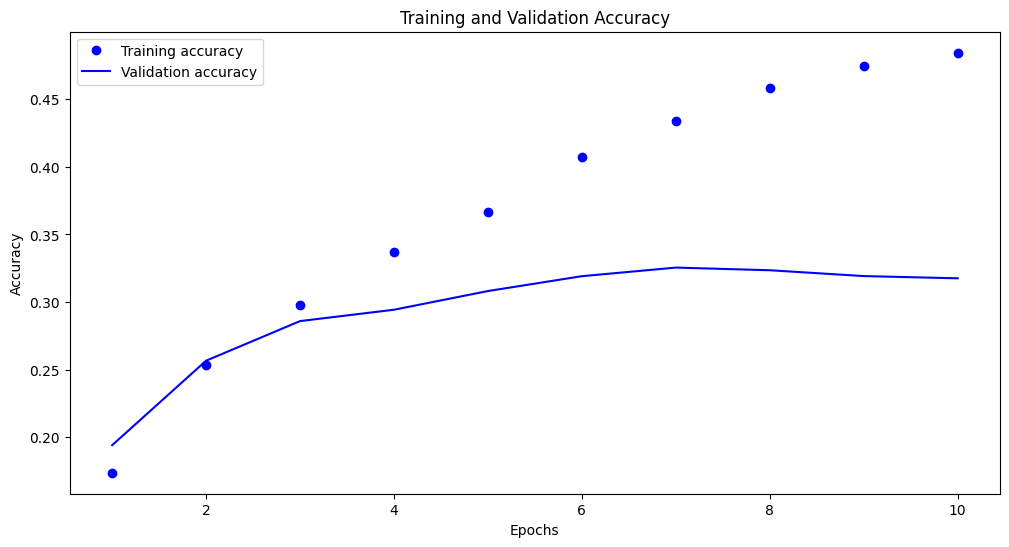

In [76]:
# Extracting accuracy and validation accuracy
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

# Extracting epochs
epochs = range(1, len(acc) + 1)

# Plotting training and validation accuracy
plt.figure(figsize=(12, 6))
plt.plot(epochs, acc, 'bo', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()
